In [291]:
#!/usr/bin/env python3
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import logging
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

#logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## 1. Phenotype Data Loading 

In [292]:
def explore_phenotype_file(base_dir="/Users/joemargolis/Desktop/Autism Project/Brain Scans"):
    """
    Explore the composite phenotype file structure with encoding detection
    """
    
    composite_file = Path(base_dir) / 'CompositePheno.csv'
    
    print(f"🔍 EXPLORING COMPOSITE PHENOTYPE FILE")
    print("=" * 50)
    
    if not composite_file.exists():
        print(f"❌ CompositePheno.csv not found at: {composite_file}")
        print("Please check the file path!")
        return None
    
    # Try different encodings
    encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252', 'utf-16']
    
    for encoding in encodings_to_try:
        try:
            print(f"   Trying encoding: {encoding}")
            # Load and examine the structure
            df_preview = pd.read_csv(composite_file, nrows=10, encoding=encoding)  # First 10 rows for preview
            full_df = pd.read_csv(composite_file, encoding=encoding)  # Full file for stats
            print(f"   ✅ Successfully loaded with {encoding} encoding")
            break
        except UnicodeDecodeError:
            print(f"   ❌ {encoding} failed")
            continue
        except Exception as e:
            print(f"   ❌ {encoding} failed: {e}")
            continue
    else:
        print("❌ Could not read file with any encoding")
        return None
    
    try:
        
        print(f"✅ Found CompositePheno.csv")
        print(f"   Successfully loaded with: {encoding}")
        print(f"   Full file shape: {full_df.shape}")
        print(f"   Columns ({len(df_preview.columns)}): {list(df_preview.columns)}")
        
        # Look for ID columns
        id_columns = [col for col in df_preview.columns if 'id' in col.lower() or 'sub' in col.lower()]
        print(f"   Potential ID columns: {id_columns}")
        
        # Check DX_GROUP if it exists
        if 'DX_GROUP' in df_preview.columns:
            dx_counts = full_df['DX_GROUP'].value_counts().sort_index()
            print(f"   DX_GROUP distribution: {dict(dx_counts)}")
            print(f"   DX_GROUP sample values: {df_preview['DX_GROUP'].dropna().tolist()}")
        else:
            print(f"   ❌ No DX_GROUP column found")
        
        # Check for site information
        site_columns = [col for col in df_preview.columns if 'site' in col.lower()]
        print(f"   Site columns: {site_columns}")
        if site_columns:
            site_counts = full_df[site_columns[0]].value_counts()
            print(f"   Sites found: {list(site_counts.index)}")
        
        # Show sample IDs
        if id_columns:
            sample_ids = df_preview[id_columns[0]].dropna().astype(str).tolist()
            print(f"   Sample subject IDs: {sample_ids}")
        
        print(f"\n📋 First few rows:")
        display_cols = [col for col in df_preview.columns if col in ['SUB_ID', 'SITE_ID', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX']][:5]
        if display_cols:
            print(df_preview[display_cols].head())
        else:
            print(df_preview.head())
        
        # Store the successful encoding for later use
        global COMPOSITE_ENCODING
        COMPOSITE_ENCODING = encoding
        
        return full_df
        
    except Exception as e:
        print(f"❌ Error processing composite file: {e}")
        return None

# Explore the composite phenotype file
composite_df = explore_phenotype_file()

🔍 EXPLORING COMPOSITE PHENOTYPE FILE
   Trying encoding: utf-8
   ❌ utf-8 failed
   Trying encoding: latin-1
   ✅ Successfully loaded with latin-1 encoding
✅ Found CompositePheno.csv
   Successfully loaded with: latin-1
   Full file shape: (1114, 348)
   Columns (348): ['SITE_ID', 'SUB_ID', 'NDAR_GUID', 'DX_GROUP', 'PDD_DSM_IV_TR', 'ASD_DSM_5', 'AGE_AT_SCAN ', 'SEX', 'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ', 'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE', 'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_R_NONVERBAL_TOTAL_BV', 'ADI_R_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE', 'ADOS_RSRCH_RELIABLE', 'ADOS_G_TOTAL', 'ADOS_G_COMM', 'ADOS_G_SOCIAL', 'ADOS_G_STEREO_BEHAV', 'ADOS_G_CREATIVITY', 'ADOS_2_SOCAFFECT', 'ADOS_2_RRB', 'ADOS_2_TOTAL', 'ADOS_2_SEVERITY_TOTAL', 'SRS_EDITION', 'SRS_VERSION', 'SRS_INFORMANT', 'SRS_TOTAL_RAW', 'SRS_AWARENESS_RAW', 'SRS_COGNITION_RAW', 'SRS_COMMUNICATION_RAW', 'SRS_MOTIVATION_RAW', 'SRS_MANNER

## 2. Phenotype Label Hashing

In [293]:
def load_labels(base_dir="/Users/joemargolis/Desktop/Autism Project/Brain Scans", keep_sites=None):
    """
    Load ABIDE labels from CompositePheno.csv
    
    Args:
        base_dir (str)
        keep_sites (list of str or None): restrict subjects to only these sites
    
    Returns:
        dict: {subject_id: label}
        dict: site_counts
        list: subject IDs kept
    """
    composite_file = Path(base_dir) / 'CompositePheno.csv'
    
    print("📋 Loading ABIDE labels from CompositePheno.csv...")
    print("=" * 50)
    
    if not composite_file.exists():
        print(f"❌ CompositePheno.csv not found at: {composite_file}")
        return {}, {}, []
    
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    pheno_df = None
    
    for enc in encodings:
        try:
            pheno_df = pd.read_csv(composite_file, encoding=enc)
            print(f"✅ Loaded with encoding: {enc}")
            break
        except Exception:
            continue
    
    if pheno_df is None:
        print("❌ Could not read CSV in any encoding.")
        return {}, {}, []
    
    id_col = next(
        (col for col in ['SUB_ID', 'subject_id', 'SUBJ_ID', 'ID', 'id'] if col in pheno_df.columns),
        None
    )
    if id_col is None:
        id_col = [col for col in pheno_df.columns if 'id' in col.lower()][0]
        print(f"⚠️ Using {id_col} as subject ID column")
    else:
        print(f"✅ Using {id_col} as subject ID column")
    
    label_mapping = {1: 1, 2: 0}
    all_labels = {}
    site_counts = {}
    
    kept_subjects = []
    
    if 'SITE_ID' in pheno_df.columns:
        sites = pheno_df['SITE_ID'].unique()
        print(f"✅ Found sites: {sites.tolist()}")
        
        for site in sites:
            site_df = pheno_df[pheno_df['SITE_ID'] == site]
            site_labels = []
            
            for _, row in site_df.iterrows():
                sid = str(row[id_col])
                dx = row['DX_GROUP']
                if pd.notna(dx) and dx in label_mapping:
                    all_labels[sid] = label_mapping[dx]
                    site_labels.append(label_mapping[dx])
            
            site_counts[site] = {
                'autism': site_labels.count(1),
                'control': site_labels.count(0),
                'total': len(site_labels)
            }
            print(f"   🏥 {site}: {site_counts[site]['autism']} Autism, {site_counts[site]['control']} Control")
    else:
        print("⚠️ No SITE_ID found, processing all subjects together.")
        for _, row in pheno_df.iterrows():
            sid = str(row[id_col])
            dx = row['DX_GROUP']
            if pd.notna(dx) and dx in label_mapping:
                all_labels[sid] = label_mapping[dx]
        site_counts["All"] = {
            "autism": list(all_labels.values()).count(1),
            "control": list(all_labels.values()).count(0),
            "total": len(all_labels),
        }
    
    if keep_sites is not None:
        pheno_df = pheno_df[pheno_df['SITE_ID'].isin(keep_sites)]
        kept_subjects = pheno_df[id_col].astype(str).tolist()
        print(f"✅ Filtering to {len(kept_subjects)} subjects from sites: {keep_sites}")
    else:
        kept_subjects = list(all_labels.keys())
    
    total_autism = sum(v['autism'] for v in site_counts.values())
    total_control = sum(v['control'] for v in site_counts.values())
    print(f"\n📊 TOTALS - Autism: {total_autism} | Control: {total_control}")
    
    return all_labels, site_counts, kept_subjects

# Load only NYU subjects:
label_dict, site_counts, trinity_subjects = load_labels(
    base_dir="/Users/joemargolis/Desktop/Autism Project/Brain Scans",
    keep_sites=["ABIDEII-TCD_1"]
)

print(f"✅ Loaded {len(trinity_subjects)} trinity subjects")


📋 Loading ABIDE labels from CompositePheno.csv...
✅ Loaded with encoding: latin-1
✅ Using SUB_ID as subject ID column
✅ Found sites: ['ABIDEII-BNI_1', 'ABIDEII-EMC_1', 'ABIDEII-ETH_1', 'ABIDEII-GU_1', 'ABIDEII-IP_1', 'ABIDEII-IU_1', 'ABIDEII-KKI_1', 'ABIDEII-KUL_3', 'ABIDEII-NYU_1', 'ABIDEII-NYU_2', 'ABIDEII-OHSU_1', 'ABIDEII-OILH_2', 'ABIDEII-SDSU_1', 'ABIDEII-SU_2', 'ABIDEII-TCD_1', 'ABIDEII-UCD_1', 'ABIDEII-UCLA_1', 'ABIDEII-U_MIA_1', 'ABIDEII-USM_1']
   🏥 ABIDEII-BNI_1: 29 Autism, 29 Control
   🏥 ABIDEII-EMC_1: 27 Autism, 27 Control
   🏥 ABIDEII-ETH_1: 13 Autism, 24 Control
   🏥 ABIDEII-GU_1: 51 Autism, 55 Control
   🏥 ABIDEII-IP_1: 22 Autism, 34 Control
   🏥 ABIDEII-IU_1: 20 Autism, 20 Control
   🏥 ABIDEII-KKI_1: 56 Autism, 155 Control
   🏥 ABIDEII-KUL_3: 28 Autism, 0 Control
   🏥 ABIDEII-NYU_1: 48 Autism, 30 Control
   🏥 ABIDEII-NYU_2: 27 Autism, 0 Control
   🏥 ABIDEII-OHSU_1: 37 Autism, 56 Control
   🏥 ABIDEII-OILH_2: 24 Autism, 35 Control
   🏥 ABIDEII-SDSU_1: 33 Autism, 25 Cont

## 3. Image Data Loading and Label Matching

In [294]:
def filter_dataset_to_subjects(dataset, subject_list):
    """
    Filter any dataset dictionary to only subjects in subject_list
    """
    if "subject_ids" not in dataset:
        return dataset
    
    subject_ids = np.array(dataset['subject_ids'])
    keep_mask = np.isin(subject_ids, list(subject_list))
    
    filtered_dataset = {}
    for key, value in dataset.items():
        if isinstance(value, np.ndarray) and len(value) == len(subject_ids):
            filtered_dataset[key] = value[keep_mask]
        elif isinstance(value, list) and len(value) == len(subject_ids):
            filtered_dataset[key] = [value[i] for i in np.where(keep_mask)[0]]
        else:
            filtered_dataset[key] = value
    
    return filtered_dataset

def prepare_individual_modalities(processed_dir="./abide_speed_optimized_features"):
    """Prepare optimized datasets for individual modality models"""
    
    subject_folders = [f for f in Path(processed_dir).iterdir() if f.is_dir() and f.name.isdigit()]
    subject_folders.sort(key=lambda x: int(x.name))
    
    print(f"🔍 PREPARING DATASETS FOR INDIVIDUAL MODELS")
    print("=" * 60)
    print(f"Found {len(subject_folders)} subjects")
    
    # Debug: Check a few subjects to understand the data structure
    print(f"\n🔍 DEBUGGING DATA STRUCTURE:")
    for i, folder in enumerate(subject_folders[:3]):
        try:
            func_dict = np.load(folder / 'functional_features.npy', allow_pickle=True).item()
            func_matrix = func_dict['correlation_matrix']
            print(f"   Subject {folder.name}: Functional matrix shape = {func_matrix.shape}")
        except Exception as e:
            print(f"   Subject {folder.name}: Error loading functional data - {e}")
    
    all_data = {
        'structural': {'node_features': [], 'subject_ids': []},
        'functional': {'connectivity_matrices': [], 'subject_ids': []},
        'dti': {'global_features': [], 'subject_ids': []}
    }
    
    successful_loads = {'structural': 0, 'functional': 0, 'dti': 0}
    
    for folder in subject_folders:
        subject_id = folder.name
        
        try:
            # Load all modality data
            struct_dict = np.load(folder / 'structural_features.npy', allow_pickle=True).item()
            func_dict = np.load(folder / 'functional_features.npy', allow_pickle=True).item()
            dti_dict = np.load(folder / 'dti_features.npy', allow_pickle=True).item()
            
            # 1. STRUCTURAL: Use ALL regions, ALL features (for StructuralMaskGNN)
            all_regions = sorted(list(struct_dict.keys()))
            structural_features = []
            
            for region in all_regions:
                region_data = struct_dict[region]
                features = []
                for key in ['volume', 'mean_intensity', 'std_intensity', 'intensity_range', 'tissue_contrast']:
                    if key in region_data:
                        features.append(float(region_data[key]))
                structural_features.append(features)
            
            # 2. FUNCTIONAL: Just connectivity matrix (FunctionalMaskGNN creates own embeddings)
            functional_connectivity = func_dict['correlation_matrix']
            functional_connectivity = np.clip(functional_connectivity, -1, 1)
            functional_connectivity = (functional_connectivity + 1) / 2
            np.fill_diagonal(functional_connectivity, 0)
            
            # 3. DTI: Comprehensive global features (for DTIMaskGNN)
            dti_features = []
            
            if 'wm_features' in dti_dict:
                wm_data = dti_dict['wm_features']
                if isinstance(wm_data, dict):
                    for key, val in sorted(wm_data.items()):
                        if isinstance(val, (int, float, np.integer, np.floating)):
                            dti_features.append(float(val))
            
            if 'regional_dti' in dti_dict:
                regional_data = dti_dict['regional_dti']
                if isinstance(regional_data, dict):
                    for key, val in sorted(regional_data.items()):
                        if isinstance(val, (int, float, np.integer, np.floating)):
                            dti_features.append(float(val))
                        elif isinstance(val, dict):
                            for subkey, subval in val.items():
                                if isinstance(subval, (int, float, np.integer, np.floating)):
                                    dti_features.append(float(subval))
            
            # Store valid data
            if len(structural_features) > 0:
                all_data['structural']['node_features'].append(np.array(structural_features))
                all_data['structural']['subject_ids'].append(subject_id)
            
            if functional_connectivity.shape == (93, 93):
                all_data['functional']['connectivity_matrices'].append(functional_connectivity)
                all_data['functional']['subject_ids'].append(subject_id)
            
            # Store valid data (avoid duplicates)
            if len(structural_features) > 0 and subject_id not in all_data['structural']['subject_ids']:
                all_data['structural']['node_features'].append(np.array(structural_features))
                all_data['structural']['subject_ids'].append(subject_id)
                successful_loads['structural'] += 1
            
            if subject_id not in all_data['dti']['subject_ids'] and len(dti_features) > 0:
                all_data['dti']['global_features'].append(np.array(dti_features))
                all_data['dti']['subject_ids'].append(subject_id)
                successful_loads['dti'] += 1
                
        except Exception as e:
            if successful_loads['structural'] + successful_loads['functional'] + successful_loads['dti'] < 10:
                print(f"   ❌ {subject_id}: {e}")
            continue
    
    # Report loading statistics
    print(f"\n📊 LOADING STATISTICS:")
    print(f"   Structural: {successful_loads['structural']} subjects")
    print(f"   Functional: {successful_loads['functional']} subjects") 
    print(f"   DTI: {successful_loads['dti']} subjects")
    
    # Create final individual datasets
    individual_datasets = {}
    
    # Debug: Check what data we actually collected
    print(f"\n🔍 DATA COLLECTION SUMMARY:")
    print(f"   Structural features collected: {len(all_data['structural']['node_features'])}")
    print(f"   Functional matrices collected: {len(all_data['functional']['connectivity_matrices'])}")
    print(f"   DTI features collected: {len(all_data['dti']['global_features'])}")
    
    if len(all_data['structural']['node_features']) > 0:
        # Remove any potential duplicates by converting to numpy array
        struct_array = np.array(all_data['structural']['node_features'])
        struct_ids = all_data['structural']['subject_ids']
        
        individual_datasets['structural'] = {
            'node_features': struct_array,
            'subject_ids': struct_ids
        }
        print(f"✅ Structural: {struct_array.shape} ({len(struct_ids)} subjects)")
    else:
        print(f"❌ No structural data collected!")
    
    if len(all_data['functional']['connectivity_matrices']) > 0:
        func_array = np.array(all_data['functional']['connectivity_matrices'])
        func_ids = all_data['functional']['subject_ids']
        
        individual_datasets['functional'] = {
            'connectivity_matrices': func_array,
            'subject_ids': func_ids
        }
        print(f"✅ Functional: {func_array.shape} ({len(func_ids)} subjects)")
    else:
        print(f"❌ No functional data collected!")
    
    if len(all_data['dti']['global_features']) > 0:
        # Standardize DTI feature length
        dti_lengths = [len(feat) for feat in all_data['dti']['global_features']]
        min_len = min(dti_lengths)
        max_len = max(dti_lengths)
        
        if min_len != max_len:
            print(f"   Standardizing DTI features: {min_len}-{max_len} → {min_len}")
            standardized_dti = [feat[:min_len] for feat in all_data['dti']['global_features']]
        else:
            standardized_dti = all_data['dti']['global_features']
        
        dti_array = np.array(standardized_dti)
        dti_ids = all_data['dti']['subject_ids']
        
        individual_datasets['dti'] = {
            'global_features': dti_array,
            'subject_ids': dti_ids
        }
        print(f"✅ DTI: {dti_array.shape} ({len(dti_ids)} subjects)")
    else:
        print(f"❌ No DTI data collected!")
    
    return individual_datasets

def prepare_unified_multimodal_data(processed_dir="./abide_speed_optimized_features"):
    """Prepare unified dataset for MultimodalMaskGNN"""
    
    subject_folders = [f for f in Path(processed_dir).iterdir() if f.is_dir() and f.name.isdigit()]
    subject_folders.sort(key=lambda x: int(x.name))
    
    print(f"\n🔄 PREPARING UNIFIED MULTIMODAL DATASET")
    print("=" * 60)
    
    # Use structural regions to match functional
    test_folder = subject_folders[0]
    struct_data = np.load(test_folder / 'structural_features.npy', allow_pickle=True).item()
    all_regions = sorted(list(struct_data.keys()))
    selected_regions = all_regions[:93]
    
    print(f"Using first 93  regions of {len(all_regions)} available")
    
    all_connectivity = []
    all_node_features = []
    all_global_features = []
    all_ids = []
    
    for folder in subject_folders:
        subject_id = folder.name
        
        try:
            struct_dict = np.load(folder / 'structural_features.npy', allow_pickle=True).item()
            func_dict = np.load(folder / 'functional_features.npy', allow_pickle=True).item()
            dti_dict = np.load(folder / 'dti_features.npy', allow_pickle=True).item()
            
            # Adjacency: Standardize functional connectivity to 19x19
            adjacency_matrix = func_dict['correlation_matrix']
            adjacency_matrix = np.clip(adjacency_matrix, -1, 1)
            adjacency_matrix = (adjacency_matrix + 1) / 2
            np.fill_diagonal(adjacency_matrix, 0)
            
            if adjacency_matrix.shape != (93, 93):
                continue
            
            # Node features: structural features for nodes
            node_features = []
            for region in selected_regions:
                if region in struct_dict:
                    region_data = struct_dict[region]
                    features = []
                    for key in ['volume', 'mean_intensity', 'std_intensity', 'intensity_range', 'tissue_contrast']:
                        if key in region_data:
                            features.append(float(region_data[key]))
                    node_features.append(features)
                else:
                    node_features.append([0.0] * 5)
            
            # Global features: DTI
            global_features = []
            if 'wm_features' in dti_dict:
                wm_data = dti_dict['wm_features']
                if isinstance(wm_data, dict):
                    for key, val in sorted(wm_data.items()):
                        if isinstance(val, (int, float, np.integer, np.floating)):
                            global_features.append(float(val))
            
            # Validate and store
            if (adjacency_matrix.shape == (93, 93) and 
                len(node_features) == 93 and
                len(global_features) > 0):
                
                all_connectivity.append(adjacency_matrix)
                all_node_features.append(np.array(node_features))
                all_global_features.append(np.array(global_features))
                all_ids.append(subject_id)
                
        except Exception as e:
            continue
    
    if len(all_ids) > 0:
        # Standardize global features
        global_lengths = [len(gf) for gf in all_global_features]
        min_len = min(global_lengths)
        if min(global_lengths) != max(global_lengths):
            all_global_features = [gf[:min_len] for gf in all_global_features]
        
        unified_dataset = {
            'connectivity_matrices': np.array(all_connectivity),
            'node_features': np.array(all_node_features), 
            'global_features': np.array(all_global_features),
            'subject_ids': all_ids
        }
        
        print(f"✅ Unified: Adj{unified_dataset['connectivity_matrices'].shape}, "
              f"Nodes{unified_dataset['node_features'].shape}, "
              f"Global{unified_dataset['global_features'].shape}")
        
        return unified_dataset
    else:
        return None

# Prepare both types of datasets
individual_datasets = prepare_individual_modalities()
unified_dataset = prepare_unified_multimodal_data()

# Match labels for all datasets
final_datasets = {}

print(f"\n🔗 MATCHING LABELS TO ALL DATASETS")
print("=" * 60)

for modality, dataset in individual_datasets.items():
    print(f"\n📊 Matching {modality.upper()} dataset...")
    
    # Simple direct matching for individual datasets
    matched_labels = {}
    valid_indices = []
    
    for i, subject_id in enumerate(dataset['subject_ids']):
        if str(subject_id) in label_dict:
            matched_labels[subject_id] = label_dict[str(subject_id)]
            valid_indices.append(i)
    
    print(f"   Direct matches: {len(valid_indices)} / {len(dataset['subject_ids'])}")
    
    # Try alternative matching if poor results
    if len(valid_indices) < len(dataset['subject_ids']) * 0.5:
        print(f"   Trying alternative ID formats...")
        
        for i, subject_id in enumerate(dataset['subject_ids']):
            if i in valid_indices:
                continue
                
            # Try with prefixes
            for prefix in ['sub-', 'SUB-', 'SUBJ-']:
                test_id = prefix + str(subject_id)
                if test_id in label_dict:
                    matched_labels[subject_id] = label_dict[test_id]
                    valid_indices.append(i)
                    print(f"     ✅ Matched {subject_id} -> {test_id}")
                    break
            
            # Try substring matching
            if i not in valid_indices:
                for label_id in label_dict.keys():
                    if str(subject_id) in label_id:
                        matched_labels[subject_id] = label_dict[label_id]
                        valid_indices.append(i)
                        print(f"     ✅ Partial match {subject_id} -> {label_id}")
                        break
    
    if len(valid_indices) > 0:
        filtered_dataset = {}
        for key, value in dataset.items():
            if key == 'subject_ids':
                filtered_dataset[key] = [dataset['subject_ids'][i] for i in valid_indices]
            else:
                filtered_dataset[key] = value[valid_indices]
        
        # Add matched labels
        labels = [matched_labels[sid] for sid in filtered_dataset['subject_ids']]
        filtered_dataset['labels'] = np.array(labels)
        final_datasets[modality] = filtered_dataset
        
        print(f"   ✅ {len(labels)} subjects matched")
        print(f"   Labels: {np.sum(np.array(labels)==1)} Autism, {np.sum(np.array(labels)==0)} Control")

# Match unified dataset
if unified_dataset is not None:
    print(f"\n🔄 Matching UNIFIED dataset...")
    
    matched_labels = {}
    valid_indices = []
    
    for i, subject_id in enumerate(unified_dataset['subject_ids']):
        if str(subject_id) in label_dict:
            matched_labels[subject_id] = label_dict[str(subject_id)]
            valid_indices.append(i)
    
    print(f"   Direct matches: {len(valid_indices)} / {len(unified_dataset['subject_ids'])}")
    
    # Try alternative matching if needed
    if len(valid_indices) < len(unified_dataset['subject_ids']) * 0.5:
        print(f"   Trying alternative ID formats...")
        
        for i, subject_id in enumerate(unified_dataset['subject_ids']):
            if i in valid_indices:
                continue
                
            # Try with prefixes
            for prefix in ['sub-', 'SUB-', 'SUBJ-']:
                test_id = prefix + str(subject_id)
                if test_id in label_dict:
                    matched_labels[subject_id] = label_dict[test_id]
                    valid_indices.append(i)
                    break
            
            # Try substring matching
            if i not in valid_indices:
                for label_id in label_dict.keys():
                    if str(subject_id) in label_id:
                        matched_labels[subject_id] = label_dict[label_id]
                        valid_indices.append(i)
                        break
    
    if len(valid_indices) > 0:
        filtered_unified = {}
        for key, value in unified_dataset.items():
            if isinstance(value, np.ndarray):
                filtered_unified[key] = value[valid_indices]
            elif isinstance(value, list):
                filtered_unified[key] = [value[i] for i in valid_indices]
            else:
                filtered_unified[key] = value
        
        # Add matched labels
        labels = [matched_labels[sid] for sid in filtered_unified['subject_ids']]
        filtered_unified['labels'] = np.array(labels)
        final_datasets['unified'] = filtered_unified
        
        print(f"   ✅ {len(labels)} subjects matched")
        print(f"   Labels: {np.sum(np.array(labels)==1)} Autism, {np.sum(np.array(labels)==0)} Control")

print(f"\n🎉 ALL DATASETS READY FOR MASKGNN TRAINING!")

print("\n🔎 QUICK DATA HEALTH CHECKS")
print("="*60)

# Check functional variability
func_data = final_datasets['functional']['connectivity_matrices']
print("Functional std across all values:", np.std(func_data))

# Compare first two matrices
if len(func_data) >= 2:
    diff = np.abs(func_data[0] - func_data[1])
    print("Mean difference between matrix 0 and 1:", np.mean(diff))
else:
    print("Not enough subjects to compare matrices!")

# Check structural variance
struct_data = final_datasets['structural']['node_features']
means_struct = np.mean(struct_data, axis=0)    # shape [93, 5]
stds_struct = np.std(struct_data, axis=0)

print("Structural mean feature values across regions [shape:", means_struct.shape, "]")
print(means_struct)

print("Structural std feature values across regions [shape:", stds_struct.shape, "]")
print(stds_struct)

# Print some subject-label pairs
print("\nExample subject-label pairs:")
for i in range(min(10, len(final_datasets['functional']['subject_ids']))):
    sid = final_datasets['functional']['subject_ids'][i]
    label = final_datasets['functional']['labels'][i]
    print(f"Subject {sid}: label = {label}")


# Remove subjects with NaNs from functional data
func_data = final_datasets['functional']['connectivity_matrices']
subject_ids = final_datasets['functional']['subject_ids']
labels = final_datasets['functional']['labels']

valid_indices = [
    i for i, mat in enumerate(func_data)
    if not np.isnan(mat).any()
]

print(f"\n✅ Keeping {len(valid_indices)} subjects without NaNs in functional data.")

final_datasets['functional'] = {
    'connectivity_matrices': func_data[valid_indices],
    'subject_ids': [subject_ids[i] for i in valid_indices],
    'labels': labels[valid_indices]
}

func_data = final_datasets['functional']['connectivity_matrices']
print("Functional std across all values:", np.std(func_data))
print("Global min:", func_data.min())
print("Global max:", func_data.max())
if len(func_data) >= 2:
    diff = np.abs(func_data[0] - func_data[1])
    print("Mean diff between first two matrices:", np.mean(diff))


# ✅ FILTER ALL DATASETS TO NYU SUBJECTS
print("\n🔎 Filtering all datasets to NYU1 subjects...")
print("="*60)

for modality in list(final_datasets.keys()):
    filtered = filter_dataset_to_subjects(final_datasets[modality], trinity_subjects)
    final_datasets[modality] = filtered
    if "subject_ids" in filtered:
        print(f"✅ {modality} Trinity subset: {len(filtered['subject_ids'])} subjects")

print("\n✅ Post-filter health checks:")
if "functional" in final_datasets:
    func_data = final_datasets['functional']['connectivity_matrices']
    print("Functional std across all values:", np.std(func_data))
    print("Functional global min:", func_data.min())
    print("Functional global max:", func_data.max())
    if len(func_data) >= 2:
        diff = np.abs(func_data[0] - func_data[1])
        print("Mean diff between first two matrices:", np.mean(diff))


print("\n🔎 RUNNING PCA ON ALL MODALITIES")
print("="*60)

from sklearn.decomposition import PCA

# -------------------------------
# FUNCTIONAL PCA
# -------------------------------

# Get functional matrices
func_data = final_datasets['functional']['connectivity_matrices']

# Vectorize upper triangle
func_vecs = np.array([
    mat[np.triu_indices(93, k=1)]
    for mat in func_data
])
print("Functional vectors shape:", func_vecs.shape)

# Compute maximum safe number of components
max_components_func = min(func_vecs.shape[0], func_vecs.shape[1], 50)

pca_func = PCA(n_components=max_components_func, random_state=42)
func_pca = pca_func.fit_transform(func_vecs)

print("Functional PCA shape:", func_pca.shape)

# -------------------------------
# STRUCTURAL PCA
# -------------------------------

# Get structural node features
struct_data = final_datasets['structural']['node_features']

# Flatten
n_subjects = struct_data.shape[0]
struct_flat = struct_data.reshape(n_subjects, -1)
print("Structural flattened shape:", struct_flat.shape)

max_components_struct = min(struct_flat.shape[0], struct_flat.shape[1], 50)
pca_struct = PCA(n_components=max_components_struct, random_state=42)
struct_pca = pca_struct.fit_transform(struct_flat)

print("Structural PCA shape:", struct_pca.shape)

# -------------------------------
# DTI PCA
# -------------------------------

# Get DTI features
dti_data = final_datasets['dti']['global_features']
print("DTI shape:", dti_data.shape)

max_components_dti = min(dti_data.shape[0], dti_data.shape[1], 10)
pca_dti = PCA(n_components=max_components_dti, random_state=42)
dti_pca = pca_dti.fit_transform(dti_data)

print("DTI PCA shape:", dti_pca.shape)

# Store into final_datasets
final_datasets['functional_pca'] = {
    'features': func_pca,
    'subject_ids': final_datasets['functional']['subject_ids'],
    'labels': final_datasets['functional']['labels']
}

final_datasets['structural_pca'] = {
    'features': struct_pca,
    'subject_ids': final_datasets['structural']['subject_ids'],
    'labels': final_datasets['structural']['labels']
}

final_datasets['dti_pca'] = {
    'features': dti_pca,
    'subject_ids': final_datasets['dti']['subject_ids'],
    'labels': final_datasets['dti']['labels']
}

print("✅ PCA features stored in final_datasets.")


🔍 PREPARING DATASETS FOR INDIVIDUAL MODELS
Found 231 subjects

🔍 DEBUGGING DATA STRUCTURE:
   Subject 28853: Functional matrix shape = (93, 93)
   Subject 28854: Functional matrix shape = (93, 93)
   Subject 28855: Functional matrix shape = (93, 93)

📊 LOADING STATISTICS:
   Structural: 0 subjects
   Functional: 0 subjects
   DTI: 229 subjects

🔍 DATA COLLECTION SUMMARY:
   Structural features collected: 229
   Functional matrices collected: 229
   DTI features collected: 229
✅ Structural: (229, 93, 5) (229 subjects)
✅ Functional: (229, 93, 93) (229 subjects)
✅ DTI: (229, 18) (229 subjects)

🔄 PREPARING UNIFIED MULTIMODAL DATASET
Using first 93  regions of 93 available
✅ Unified: Adj(229, 93, 93), Nodes(229, 93, 5), Global(229, 4)

🔗 MATCHING LABELS TO ALL DATASETS

📊 Matching STRUCTURAL dataset...
   Direct matches: 229 / 229
   ✅ 229 subjects matched
   Labels: 134 Autism, 95 Control

📊 Matching FUNCTIONAL dataset...
   Direct matches: 229 / 229
   ✅ 229 subjects matched
   Labels: 1

In [295]:
# Check if there are NaNs in the functional connectivity matrices
func_data = final_datasets['functional']['connectivity_matrices']

num_nan_matrices = np.sum([np.isnan(mat).any() for mat in func_data])
print(f"\n🚨 Matrices containing NaNs: {num_nan_matrices} / {len(func_data)}")

# Identify which subjects
for i, mat in enumerate(func_data):
    if np.isnan(mat).any():
        sid = final_datasets['functional']['subject_ids'][i]
        print(f"❌ Subject {sid} has NaNs in functional matrix.")

func_data = final_datasets['functional']['connectivity_matrices']
print(f"Functional matrix shape: {func_data.shape}")
print(f"Global min: {np.nanmin(func_data)}")
print(f"Global max: {np.nanmax(func_data)}")

# Logistic regression quick test
print("\n🔎 Running quick logistic regression sanity check...")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

X = final_datasets['functional']['connectivity_matrices']
y = final_datasets['functional']['labels']

# Flatten matrices into vectors for classifier
X_flat = X.reshape(X.shape[0], -1)

# Scale features
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# Run logistic regression with 5-fold CV
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, X_flat_scaled, y, cv=5)

print("Logistic Regression CV Accuracy:", scores.mean())


# Check for infinities
print(f"Any infinities? {np.isinf(func_data).any()}")

A = func_data[0]
degrees = A.sum(axis=1)
print("Degree min:", degrees.min())
print("Degree max:", degrees.max())
print("Any negative degrees?", (degrees < 0).any())

print(f"\n✅ Keeping {len(valid_indices)} subjects without NaNs in functional data.")





🚨 Matrices containing NaNs: 0 / 40
Functional matrix shape: (40, 93, 93)
Global min: 0.0
Global max: 0.9970929479693038

🔎 Running quick logistic regression sanity check...
Logistic Regression CV Accuracy: 0.5
Any infinities? False
Degree min: 36.47924139735861
Degree max: 65.75882413884584
Any negative degrees? False

✅ Keeping 177 subjects without NaNs in functional data.


## 4. MaskGNN Pipeline Definitions

In [296]:
class MaskGCNLayer(nn.Module):
    """
    Masked Graph Convolutional Layer with learnable edge weights
    """
    
    def __init__(self, in_features, out_features, dropout=0.5):
        super(MaskGCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight matrix for node features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        
        # Learnable mask for edge weights
        self.edge_mask = nn.Parameter(torch.FloatTensor(1, 1))
        
        self.dropout = nn.Dropout(dropout)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.constant_(self.edge_mask, 1.0)
    
    def forward(self, x, adj):
        """
        Forward pass with masked adjacency matrix
        
        Args:
            x: Node features [batch_size, num_nodes, in_features]
            adj: Adjacency matrix [batch_size, num_nodes, num_nodes]
        """
        # Apply learnable mask to adjacency matrix
        masked_adj = adj * torch.sigmoid(self.edge_mask)
        
        # Add identity matrix to prevent degeneration
        identity = torch.eye(adj.size(-1), device=adj.device).unsqueeze(0)
        masked_adj = masked_adj + identity
        
        # Normalize adjacency matrix
        degree = torch.sum(masked_adj, dim=-1, keepdim=True)
        degree = torch.pow(degree, -0.5)
        degree[degree == float('inf')] = 0
        norm_adj = degree * masked_adj * degree.transpose(-2, -1)
        
        # Apply transformation
        x = torch.matmul(x, self.weight)
        x = torch.matmul(norm_adj, x)
        x = self.dropout(x)
        
        return F.relu(x), masked_adj

class StructuralMaskGNN(nn.Module):
    """
    MaskGNN for Structural MRI data only
    """
    
    def __init__(self, num_nodes=22, node_features=5, hidden_dim=64, 
                 num_classes=2, dropout=0.5):
        super(StructuralMaskGNN, self).__init__()
        
        self.num_nodes = num_nodes
        self.node_features = node_features
        
        # GCN layers
        self.gcn1 = MaskGCNLayer(node_features, hidden_dim, dropout)
        self.gcn2 = MaskGCNLayer(hidden_dim, hidden_dim, dropout)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, node_features, adj_matrix=None):
        """
        Forward pass for structural data
        """
        batch_size = node_features.size(0)
        
        # Create identity adjacency if none provided (for structural features)
        if adj_matrix is None:
            adj_matrix = torch.eye(self.num_nodes, device=node_features.device).unsqueeze(0).repeat(batch_size, 1, 1)
        
        # GCN layers
        x, mask1 = self.gcn1(node_features, adj_matrix)
        x, mask2 = self.gcn2(x, adj_matrix)
        
        # Global pooling
        x = x.transpose(1, 2)  # [batch_size, features, nodes]
        x = self.global_pool(x).squeeze(-1)  # [batch_size, features]
        
        # Classification
        output = self.classifier(x)
        
        return {
            'logits': output,
            'node_embeddings': x,
            'masks': [mask1, mask2]
        }

class FunctionalMaskGNN(nn.Module):
    """
    MaskGNN for Functional MRI connectivity data
    """
    def __init__(self, num_nodes=93, hidden_dim=64, num_classes=2, dropout=0.5):
        super().__init__()    # ✅ REQUIRED
        
        self.num_nodes = num_nodes
        
        # Initial node embedding (since functional data has no initial node features)
        self.node_embedding = nn.Parameter(torch.randn(num_nodes, hidden_dim))
        
        # GCN layers
        self.gcn1 = MaskGCNLayer(hidden_dim, hidden_dim, dropout)
        self.gcn2 = MaskGCNLayer(hidden_dim, hidden_dim, dropout)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, connectivity_matrix):
        """
        Forward pass for functional connectivity data
        """
        batch_size = connectivity_matrix.size(0)
        
        # Expand node embeddings for batch
        x = self.node_embedding.unsqueeze(0).repeat(batch_size, 1, 1)
        
        # GCN layers with connectivity as adjacency
        x, mask1 = self.gcn1(x, connectivity_matrix)
        x, mask2 = self.gcn2(x, connectivity_matrix)
        
        # Global pooling
        x = x.transpose(1, 2)  # [batch_size, features, nodes]
        x = self.global_pool(x).squeeze(-1)  # [batch_size, features]
        
        # Classification
        output = self.classifier(x)
        
        return {
            'logits': output,
            'node_embeddings': x,
            'masks': [mask1, mask2]
        }

class DTIMaskGNN(nn.Module):
    """
    MaskGNN for DTI global features (graph-level features only)
    """
    
    def __init__(self, global_features=18, hidden_dim=64, num_classes=2, dropout=0.5):
        super(DTIMaskGNN, self).__init__()
        
        # DTI features are global, so simple MLP
        self.feature_processor = nn.Sequential(
            nn.Linear(global_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, global_features):
        """
        Forward pass for DTI global features
        """
        x = self.feature_processor(global_features)
        output = self.classifier(x)
        
        return {
            'logits': output,
            'node_embeddings': x,
            'masks': []  # No masks for global features
        }

class MultimodalMaskGNN(nn.Module):
    """
    Multimodal MaskGNN that fuses structural, functional, and DTI data
    """
    
    def __init__(self, num_nodes=93, node_features=5, global_features=4, 
                 hidden_dim=64, num_classes=2, dropout=0.5, fusion_method='attention'):
        super(MultimodalMaskGNN, self).__init__()
        
        self.fusion_method = fusion_method
        
        # Individual modality encoders
        self.structural_encoder = self._build_structural_encoder(
            num_nodes, node_features, hidden_dim, dropout
        )
        self.functional_encoder = self._build_functional_encoder(
            num_nodes, hidden_dim, dropout
        )
        self.dti_encoder = self._build_dti_encoder(
            global_features, hidden_dim, dropout
        )
        
        # Fusion layer
        if fusion_method == 'concat':
            fusion_input_dim = hidden_dim * 3
        elif fusion_method == 'attention':
            fusion_input_dim = hidden_dim
            self.attention_weights = nn.Parameter(torch.ones(3))
        else:  # mean
            fusion_input_dim = hidden_dim
        
        # Final classifier
        self.fusion_classifier = nn.Sequential(
            nn.Linear(fusion_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def _build_structural_encoder(self, num_nodes, node_features, hidden_dim, dropout):
        return nn.ModuleDict({
            'gcn1': MaskGCNLayer(node_features, hidden_dim, dropout),
            'gcn2': MaskGCNLayer(hidden_dim, hidden_dim, dropout),
            'pool': nn.AdaptiveAvgPool1d(1)
        })
    
    def _build_functional_encoder(self, num_nodes, hidden_dim, dropout):
        # Register the node embedding as a parameter separately
        self.register_parameter('functional_embedding', nn.Parameter(torch.randn(num_nodes, hidden_dim)))

        # Return the rest as a ModuleDict
        return nn.ModuleDict({
            'gcn1': MaskGCNLayer(hidden_dim, hidden_dim, dropout),
            'gcn2': MaskGCNLayer(hidden_dim, hidden_dim, dropout),
            'pool': nn.AdaptiveAvgPool1d(1)
        })
    
    def _build_dti_encoder(self, global_features, hidden_dim, dropout):
        return nn.Sequential(
            nn.Linear(global_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
    def forward(self, node_features, connectivity_matrix, global_features):
        """
        Forward pass for multimodal data
        """
        batch_size = node_features.size(0)
        all_masks = []
        
        # Structural encoding
        struct_adj = torch.eye(node_features.size(1), device=node_features.device).unsqueeze(0).repeat(batch_size, 1, 1)
        x_struct, mask1 = self.structural_encoder['gcn1'](node_features, struct_adj)
        x_struct, mask2 = self.structural_encoder['gcn2'](x_struct, struct_adj)
        x_struct = x_struct.transpose(1, 2)
        x_struct = self.structural_encoder['pool'](x_struct).squeeze(-1)
        all_masks.extend([mask1, mask2])
        
        # Functional encoding
        x_func = self.functional_embedding.unsqueeze(0).repeat(batch_size, 1, 1)
        x_func, mask3 = self.functional_encoder['gcn1'](x_func, connectivity_matrix)
        x_func, mask4 = self.functional_encoder['gcn2'](x_func, connectivity_matrix)
        x_func = x_func.transpose(1, 2)
        x_func = self.functional_encoder['pool'](x_func).squeeze(-1)
        all_masks.extend([mask3, mask4])
        
        # DTI encoding
        x_dti = self.dti_encoder(global_features)
        
        # Fusion
        if self.fusion_method == 'concat':
            fused = torch.cat([x_struct, x_func, x_dti], dim=1)
        elif self.fusion_method == 'attention':
            weights = F.softmax(self.attention_weights, dim=0)
            fused = weights[0] * x_struct + weights[1] * x_func + weights[2] * x_dti
        else:  # mean
            fused = (x_struct + x_func + x_dti) / 3
        
        # Final classification
        output = self.fusion_classifier(fused)
        
        return {
            'logits': output,
            'structural_embeddings': x_struct,
            'functional_embeddings': x_func,
            'dti_embeddings': x_dti,
            'fused_embeddings': fused,
            'masks': all_masks,
            'attention_weights': getattr(self, 'attention_weights', None)
        }

print("✅ MaskGNN model classes defined successfully!")
print("Models available:")
print("  - StructuralMaskGNN: For structural MRI data")
print("  - FunctionalMaskGNN: For functional connectivity data") 
print("  - DTIMaskGNN: For DTI global features")
print("  - MultimodalMaskGNN: Fusion of all three modalities")

✅ MaskGNN model classes defined successfully!
Models available:
  - StructuralMaskGNN: For structural MRI data
  - FunctionalMaskGNN: For functional connectivity data
  - DTIMaskGNN: For DTI global features
  - MultimodalMaskGNN: Fusion of all three modalities


## Model Training Pipeline Building

In [297]:
class BrainDataset(Dataset):
    """
    Dataset class for brain imaging data
    """
    
    def __init__(self, data_dict, indices=None):
        """
        Args:
            data_dict: Dictionary containing the data (from final_datasets)
            indices: Optional indices to subset the data
        """
        if indices is not None:
            # Subset the data
            self.labels = data_dict['labels'][indices]
            self.subject_ids = [data_dict['subject_ids'][i] for i in indices]
            
            # Handle different data types
            if 'connectivity_matrices' in data_dict:
                self.connectivity_matrices = data_dict['connectivity_matrices'][indices]
            else:
                self.connectivity_matrices = None
                
            if 'node_features' in data_dict:
                self.node_features = data_dict['node_features'][indices]
            else:
                self.node_features = None
                
            if 'global_features' in data_dict:
                self.global_features = data_dict['global_features'][indices]
            else:
                self.global_features = None
        else:
            # Use all data
            self.labels = data_dict['labels']
            self.subject_ids = data_dict['subject_ids']
            self.connectivity_matrices = data_dict.get('connectivity_matrices', None)
            self.node_features = data_dict.get('node_features', None)
            self.global_features = data_dict.get('global_features', None)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {
            'labels': torch.LongTensor([self.labels[idx]])[0],
            'subject_id': self.subject_ids[idx]
        }
        
        if self.connectivity_matrices is not None:
            item['connectivity_matrix'] = torch.FloatTensor(self.connectivity_matrices[idx])
            
        if self.node_features is not None:
            item['node_features'] = torch.FloatTensor(self.node_features[idx])
            
        if self.global_features is not None:
            item['global_features'] = torch.FloatTensor(self.global_features[idx])
            
        return item

class MaskGNNTrainer:
    """
    Trainer class for MaskGNN models
    """
    
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.history = {
            'epoch': [],
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
    
    def train_epoch(self, dataloader, optimizer, criterion):
        self.model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        
        for batch in dataloader:
            optimizer.zero_grad()
            
            # Move data to device
            batch = {k: v.to(self.device) if torch.is_tensor(v) else v for k, v in batch.items()}
            
            # Forward pass based on model type
            if isinstance(self.model, MultimodalMaskGNN):
                outputs = self.model(
                    batch['node_features'], 
                    batch['connectivity_matrix'], 
                    batch['global_features']
                )
            elif isinstance(self.model, StructuralMaskGNN):
                outputs = self.model(batch['node_features'])
            elif isinstance(self.model, FunctionalMaskGNN):
                outputs = self.model(batch['connectivity_matrix'])
            else:  # DTIMaskGNN
                outputs = self.model(batch['global_features'])
            
            # Calculate loss
            loss = criterion(outputs['logits'], batch['labels'])
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            predictions = torch.argmax(outputs['logits'], dim=1)
            total_correct += (predictions == batch['labels']).sum().item()
            total_samples += batch['labels'].size(0)
        
        avg_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples
        
        return avg_loss, accuracy
    
    def validate(self, dataloader, criterion):
        self.model.eval()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        all_predictions = []
        all_labels = []
        all_probabilities = []
        
        with torch.no_grad():
            for batch in dataloader:
                # Move data to device
                batch = {k: v.to(self.device) if torch.is_tensor(v) else v for k, v in batch.items()}
                
                # Forward pass based on model type
                if isinstance(self.model, MultimodalMaskGNN):
                    outputs = self.model(
                        batch['node_features'], 
                        batch['connectivity_matrix'], 
                        batch['global_features']
                    )
                elif isinstance(self.model, StructuralMaskGNN):
                    outputs = self.model(batch['node_features'])
                elif isinstance(self.model, FunctionalMaskGNN):
                    outputs = self.model(batch['connectivity_matrix'])
                else:  # DTIMaskGNN
                    outputs = self.model(batch['global_features'])
                
                # Calculate loss
                loss = criterion(outputs['logits'], batch['labels'])
                
                # Track metrics
                total_loss += loss.item()
                predictions = torch.argmax(outputs['logits'], dim=1)
                probabilities = F.softmax(outputs['logits'], dim=1)
                total_correct += (predictions == batch['labels']).sum().item()
                total_samples += batch['labels'].size(0)
                
                all_predictions.extend(predictions.cpu().tolist())
                all_labels.extend(batch['labels'].cpu().tolist())
                all_probabilities.extend(probabilities.cpu().tolist())
        
        avg_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples
        
        return avg_loss, accuracy, all_predictions, all_labels, all_probabilities
    
    def train(self, train_loader, val_loader, num_epochs=100, lr=0.001, weight_decay=1e-4):
        # Use class weights to handle imbalance (134 Autism, 95 Control)
        class_weights = torch.FloatTensor([134/229, 95/229]).to(self.device)  # Inverse frequency
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
        
        best_val_acc = 0
        best_model_state = None
        patience_counter = 0
        early_stopping_patience = 20
        
        print(f"🚀 Starting training for {num_epochs} epochs...")
        print(f"   Learning rate: {lr}")
        print(f"   Weight decay: {weight_decay}")
        print(f"   Using class weights: {class_weights.cpu().tolist()}")

        
        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            
            # Validation
            val_loss, val_acc, val_preds, val_labels, val_probs = self.validate(val_loader, criterion)
            
            # Update scheduler
            scheduler.step(val_loss)
            
            # Track metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)
            
            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Print progress
            if epoch % 10 == 0 or epoch == num_epochs - 1:
                print(f'Epoch {epoch:03d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                      f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            
            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
        
        print(f"✅ Training completed! Best validation accuracy: {best_val_acc:.4f}")
        return best_val_acc
    
    def plot_training_curves(self):
        """Plot training and validation curves"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curves
        ax1.plot(self.train_losses, label='Train Loss', color='blue')
        ax1.plot(self.val_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy curves
        ax2.plot(self.train_accs, label='Train Accuracy', color='blue')
        ax2.plot(self.val_accs, label='Validation Accuracy', color='red')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Test the training infrastructure with your data
if 'final_datasets' in locals():
    print("✅ Training infrastructure ready!")
    print(f"Available datasets: {list(final_datasets.keys())}")
    print(f"Ready to train on {len(final_datasets['structural']['labels'])} subjects")
    print(f"Each dataset includes proper data loaders and training utilities")
    
    # Create a sample dataset to test
    sample_dataset = BrainDataset(final_datasets['structural'])
    print(f"✅ Sample dataset created with {len(sample_dataset)} subjects")
    
else:
    print("⚠️ Please run the data preparation section first")

✅ Training infrastructure ready!
Available datasets: ['structural', 'functional', 'dti', 'unified', 'functional_pca', 'structural_pca', 'dti_pca']
Ready to train on 40 subjects
Each dataset includes proper data loaders and training utilities
✅ Sample dataset created with 40 subjects


## Baseline (One Modality) Training

### Structural MRI Model

🧠 Training Structural MaskGNN...
Training set: 28 subjects
Validation set: 12 subjects
Model parameters: 6,564
🚀 Starting training for 100 epochs...
   Learning rate: 0.001
   Weight decay: 0.0001
   Using class weights: [0.5851528644561768, 0.41484716534614563]
Epoch 000: Train Loss: 10.4108, Train Acc: 0.5357, Val Loss: 1.6384, Val Acc: 0.5000
Epoch 010: Train Loss: 2.7299, Train Acc: 0.5000, Val Loss: 6.7568, Val Acc: 0.5000
Epoch 020: Train Loss: 0.7581, Train Acc: 0.5357, Val Loss: 0.6931, Val Acc: 0.5000
Early stopping at epoch 20
✅ Training completed! Best validation accuracy: 0.5000

✅ Structural MaskGNN training completed!
Best validation accuracy: 0.5000

📊 Training Curves:


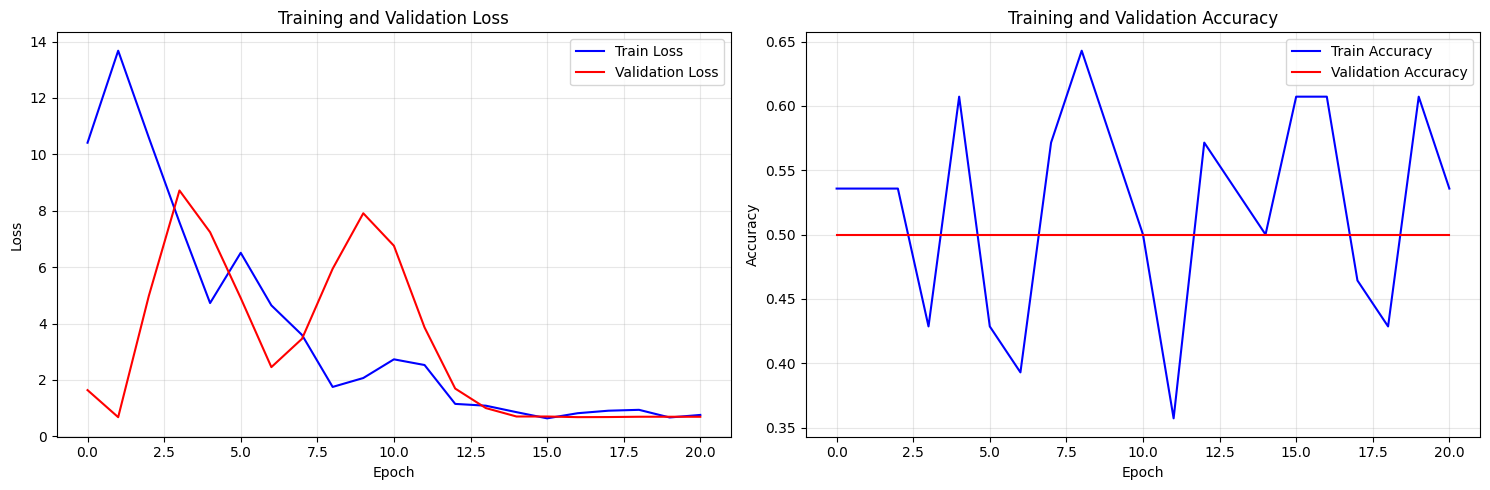

In [298]:
def train_structural_maskgnn():
    """Train MaskGNN on structural MRI data only"""
    
    print("🧠 Training Structural MaskGNN...")
    print("=" * 50)
    
    # Create train/validation split
    structural_data = final_datasets['structural']
    indices = np.arange(len(structural_data['labels']))
    train_idx, val_idx = train_test_split(
        indices, test_size=0.3, random_state=42, 
        stratify=structural_data['labels']
    )
    
    # Create datasets
    train_dataset = BrainDataset(structural_data, train_idx)
    val_dataset = BrainDataset(structural_data, val_idx)
    
    print(f"Training set: {len(train_dataset)} subjects")
    print(f"Validation set: {len(val_dataset)} subjects")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Initialize model with correct dimensions
    structural_model = StructuralMaskGNN(
        num_nodes=93,  # Your structural data has 22 regions
        node_features=5,  # 5 features per region
        hidden_dim=64,
        num_classes=2,
        dropout=0.3
    )
    
    print(f"Model parameters: {sum(p.numel() for p in structural_model.parameters()):,}")
    
    # Initialize trainer
    structural_trainer = MaskGNNTrainer(structural_model, device)
    
    # Train model
    best_acc = structural_trainer.train(
        train_loader, val_loader, 
        num_epochs=100, 
        lr=0.001, 
        weight_decay=1e-4
    )
    
    print(f"\n✅ Structural MaskGNN training completed!")
    print(f"Best validation accuracy: {best_acc:.4f}")
    
    return structural_trainer

# Train structural model
if 'final_datasets' in locals() and 'structural' in final_datasets:
    structural_trainer = train_structural_maskgnn()
    
    # Plot training curves
    print("\n📊 Training Curves:")
    structural_trainer.plot_training_curves()
else:
    print("⚠️ Please run the data preparation section first")

### Functional MRI Model

🔗 Training Functional MaskGNN...
Training set: 28 subjects
Validation set: 12 subjects
Model parameters: 16,292
🚀 Starting training for 100 epochs...
   Learning rate: 0.001
   Weight decay: 0.0001
   Using class weights: [0.5851528644561768, 0.41484716534614563]
Epoch 000: Train Loss: 0.6943, Train Acc: 0.4643, Val Loss: 0.6922, Val Acc: 0.5000
Epoch 010: Train Loss: 0.7038, Train Acc: 0.5000, Val Loss: 0.6792, Val Acc: 0.5000
Epoch 020: Train Loss: 0.6939, Train Acc: 0.5000, Val Loss: 0.6791, Val Acc: 0.5000
Early stopping at epoch 20
✅ Training completed! Best validation accuracy: 0.5000

✅ Functional MaskGNN training completed!
Best validation accuracy: 0.5000

📊 Training Curves:


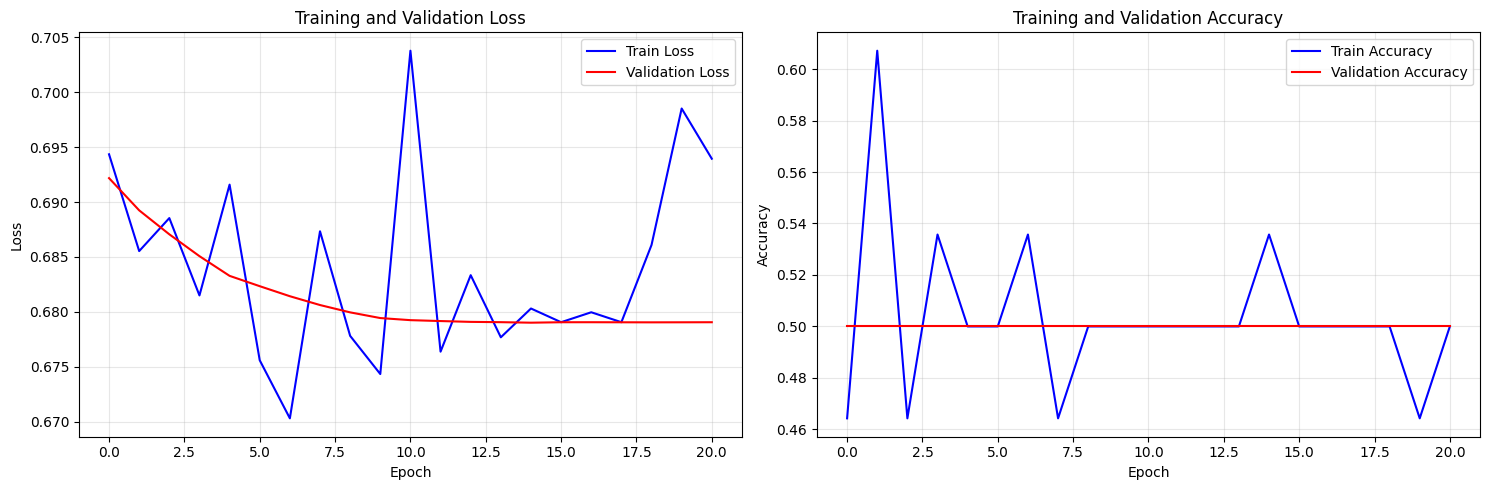

In [299]:
def train_functional_maskgnn():
    """Train MaskGNN on functional connectivity data only"""
    
    print("🔗 Training Functional MaskGNN...")
    print("=" * 50)
    
    # Create train/validation split
    functional_data = final_datasets['functional']
    indices = np.arange(len(functional_data['labels']))
    train_idx, val_idx = train_test_split(
        indices, test_size=0.3, random_state=42, 
        stratify=functional_data['labels']
    )
    
    # Create datasets
    train_dataset = BrainDataset(functional_data, train_idx)
    val_dataset = BrainDataset(functional_data, val_idx)
    
    print(f"Training set: {len(train_dataset)} subjects")
    print(f"Validation set: {len(val_dataset)} subjects")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Initialize model
    functional_model = FunctionalMaskGNN(
        num_nodes=93,
        hidden_dim=64,
        num_classes=2,
        dropout=0.3
    )
    
    print(f"Model parameters: {sum(p.numel() for p in functional_model.parameters()):,}")
    
    # Initialize trainer
    functional_trainer = MaskGNNTrainer(functional_model, device)
    
    # Train model
    best_acc = functional_trainer.train(
        train_loader, val_loader, 
        num_epochs=100, 
        lr=0.001, 
        weight_decay=1e-4
    )
    
    print(f"\n✅ Functional MaskGNN training completed!")
    print(f"Best validation accuracy: {best_acc:.4f}")
    
    return functional_trainer

# Train functional model
if 'final_datasets' in locals() and 'functional' in final_datasets:
    functional_trainer = train_functional_maskgnn()
    
    # Plot training curves
    print("\n📊 Training Curves:")
    functional_trainer.plot_training_curves()
else:
    print("⚠️ Please run the data preparation section first")

### DTI Model

🧲 Training DTI MaskGNN...
Training set: 28 subjects
Validation set: 12 subjects
Model parameters: 7,522
🚀 Starting training for 100 epochs...
   Learning rate: 0.001
   Weight decay: 0.0001
   Using class weights: [0.5851528644561768, 0.41484716534614563]
Epoch 000: Train Loss: 873.6522, Train Acc: 0.5000, Val Loss: 271.2490, Val Acc: 0.5000
Epoch 010: Train Loss: 273.1535, Train Acc: 0.4286, Val Loss: 61.0345, Val Acc: 0.5000
Epoch 020: Train Loss: 166.8916, Train Acc: 0.5714, Val Loss: 5.2676, Val Acc: 0.5000
Early stopping at epoch 20
✅ Training completed! Best validation accuracy: 0.5000

✅ DTI MaskGNN training completed!
Best validation accuracy: 0.5000

📊 Training Curves:


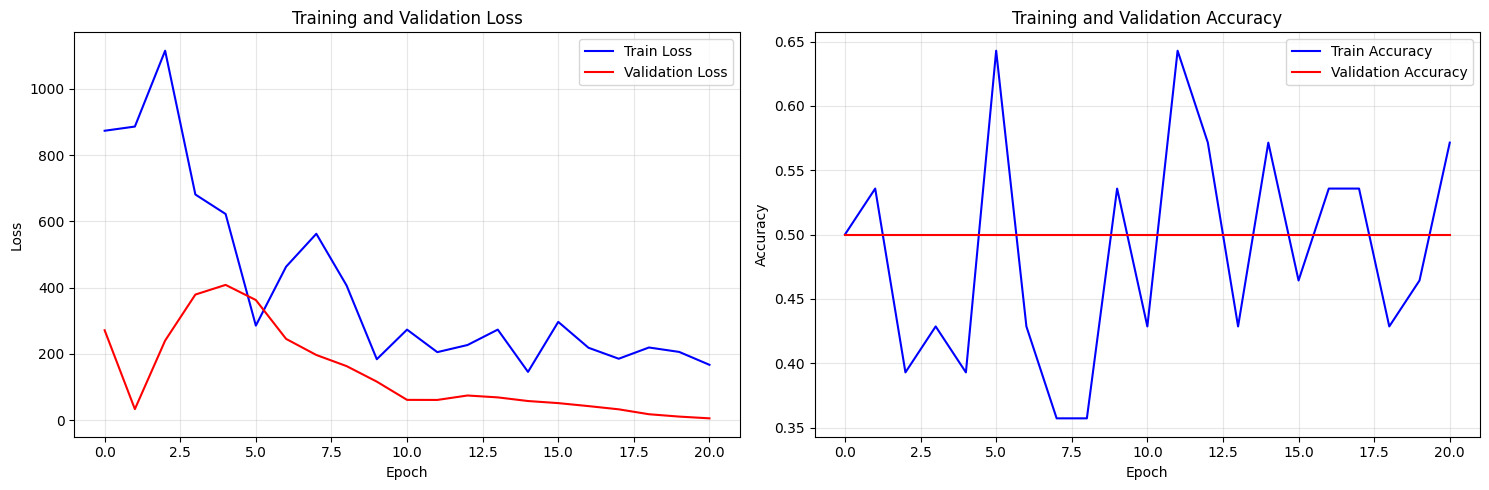

In [300]:
def train_dti_maskgnn():
    """Train MaskGNN on DTI global features only"""
    
    print("🧲 Training DTI MaskGNN...")
    print("=" * 50)
    
    # Create train/validation split
    dti_data = final_datasets['dti']
    indices = np.arange(len(dti_data['labels']))
    train_idx, val_idx = train_test_split(
        indices, test_size=0.3, random_state=42, 
        stratify=dti_data['labels']
    )
    
    # Create datasets
    train_dataset = BrainDataset(dti_data, train_idx)
    val_dataset = BrainDataset(dti_data, val_idx)
    
    print(f"Training set: {len(train_dataset)} subjects")
    print(f"Validation set: {len(val_dataset)} subjects")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Initialize model
    dti_model = DTIMaskGNN(
        global_features=18,  # Your DTI data has 18 features
        hidden_dim=64,
        num_classes=2,
        dropout=0.3
    )
    
    print(f"Model parameters: {sum(p.numel() for p in dti_model.parameters()):,}")
    
    # Initialize trainer
    dti_trainer = MaskGNNTrainer(dti_model, device)
    
    # Train model
    best_acc = dti_trainer.train(
        train_loader, val_loader, 
        num_epochs=100, 
        lr=0.001, 
        weight_decay=1e-4
    )
    
    print(f"\n✅ DTI MaskGNN training completed!")
    print(f"Best validation accuracy: {best_acc:.4f}")
    
    return dti_trainer

# Train DTI model
if 'final_datasets' in locals() and 'dti' in final_datasets:
    dti_trainer = train_dti_maskgnn()
    
    # Plot training curves
    print("\n📊 Training Curves:")
    dti_trainer.plot_training_curves()
else:
    print("⚠️ Please run the data preparation section first")

In [301]:
## Multimodal Model


🔄 Training Multimodal MaskGNN (fusion: concat)...
Training set: 28 subjects
Validation set: 12 subjects
Model parameters: 37,542
🚀 Starting training for 100 epochs...
   Learning rate: 0.001
   Weight decay: 0.0001
   Using class weights: [0.5851528644561768, 0.41484716534614563]
Epoch 000: Train Loss: 643.5262, Train Acc: 0.4643, Val Loss: 103.7292, Val Acc: 0.5000
Epoch 010: Train Loss: 129.9571, Train Acc: 0.5714, Val Loss: 37.0800, Val Acc: 0.5000
Epoch 020: Train Loss: 101.3892, Train Acc: 0.4643, Val Loss: 17.8538, Val Acc: 0.5000
Early stopping at epoch 20
✅ Training completed! Best validation accuracy: 0.5000

✅ Multimodal MaskGNN training completed!
Best validation accuracy: 0.5000

📊 Training Curves for Concat Fusion:


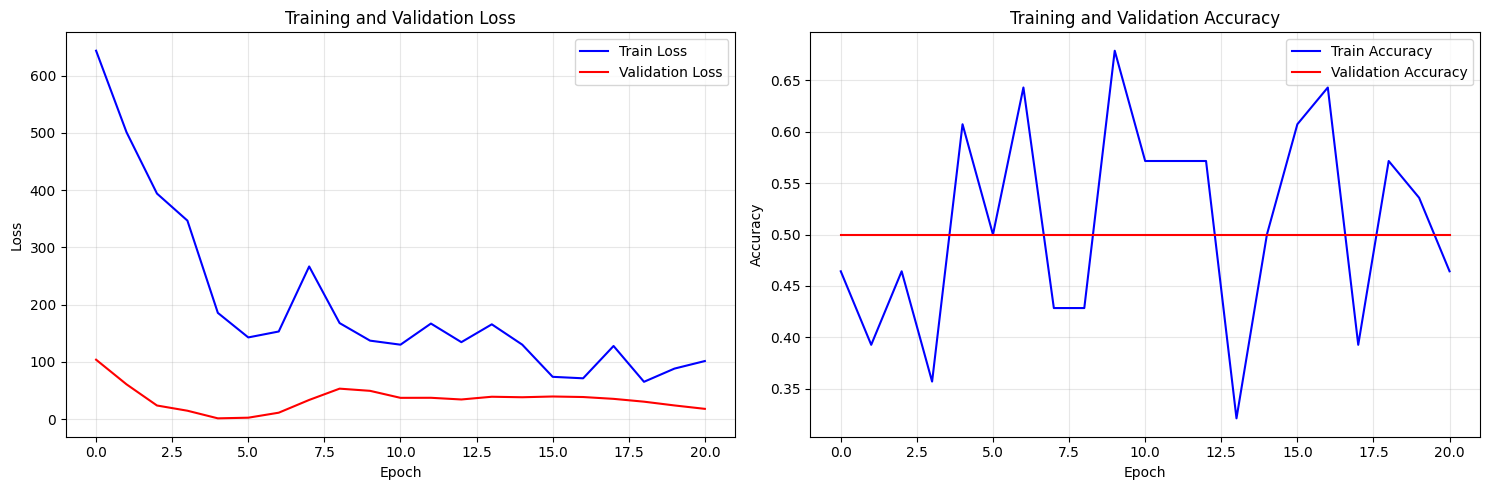


🔄 Training Multimodal MaskGNN (fusion: attention)...
Training set: 28 subjects
Validation set: 12 subjects
Model parameters: 29,353
🚀 Starting training for 100 epochs...
   Learning rate: 0.001
   Weight decay: 0.0001
   Using class weights: [0.5851528644561768, 0.41484716534614563]
Epoch 000: Train Loss: 149.1313, Train Acc: 0.5357, Val Loss: 56.0623, Val Acc: 0.5000
Epoch 010: Train Loss: 82.8109, Train Acc: 0.5357, Val Loss: 2.4142, Val Acc: 0.5000
Epoch 020: Train Loss: 35.4895, Train Acc: 0.5714, Val Loss: 2.6904, Val Acc: 0.5000
Early stopping at epoch 20
✅ Training completed! Best validation accuracy: 0.5000

✅ Multimodal MaskGNN training completed!
Best validation accuracy: 0.5000

📊 Training Curves for Attention Fusion:


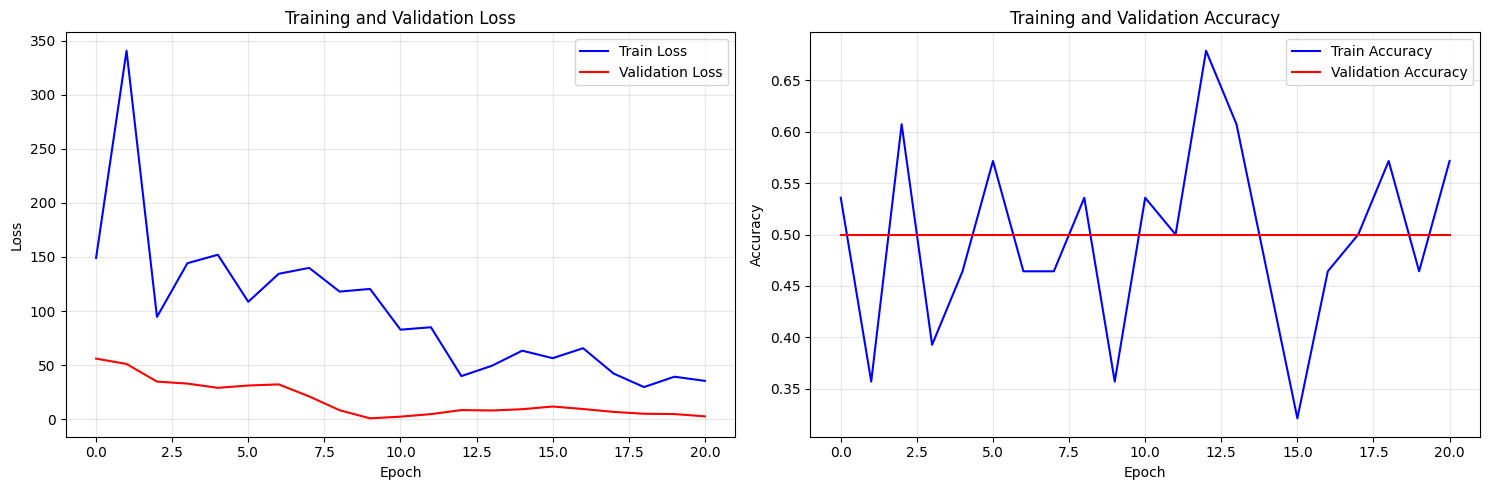


🔄 Training Multimodal MaskGNN (fusion: mean)...
Training set: 28 subjects
Validation set: 12 subjects
Model parameters: 29,350
🚀 Starting training for 100 epochs...
   Learning rate: 0.001
   Weight decay: 0.0001
   Using class weights: [0.5851528644561768, 0.41484716534614563]
Epoch 000: Train Loss: 417.6174, Train Acc: 0.3929, Val Loss: 170.5663, Val Acc: 0.5000
Epoch 010: Train Loss: 128.3712, Train Acc: 0.5714, Val Loss: 9.3972, Val Acc: 0.5000
Epoch 020: Train Loss: 80.8491, Train Acc: 0.3929, Val Loss: 54.4288, Val Acc: 0.5000
Early stopping at epoch 20
✅ Training completed! Best validation accuracy: 0.5000

✅ Multimodal MaskGNN training completed!
Best validation accuracy: 0.5000

📊 Training Curves for Mean Fusion:


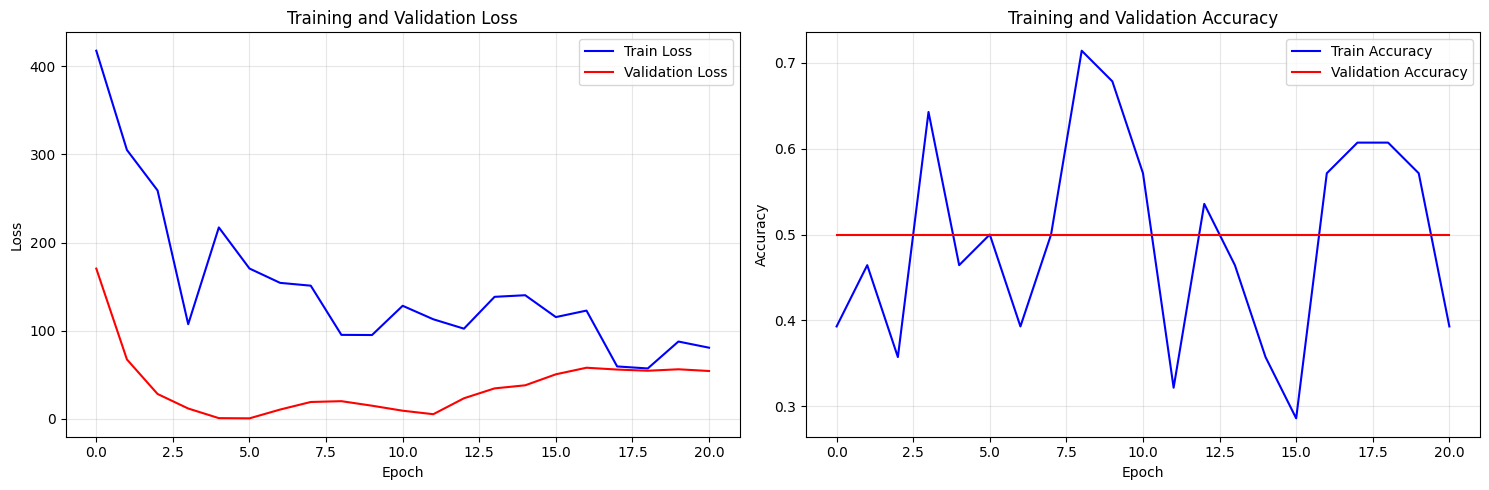

In [302]:
def train_multimodal_maskgnn(fusion_method='attention'):
    """Train multimodal MaskGNN with all three modalities"""
    
    print(f"🔄 Training Multimodal MaskGNN (fusion: {fusion_method})...")
    print("=" * 60)
    
    # Create train/validation split
    unified_data = final_datasets['unified']
    indices = np.arange(len(unified_data['labels']))
    train_idx, val_idx = train_test_split(
        indices, test_size=0.3, random_state=42, 
        stratify=unified_data['labels']
    )
    
    # Create datasets
    train_dataset = BrainDataset(unified_data, train_idx)
    val_dataset = BrainDataset(unified_data, val_idx)
    
    print(f"Training set: {len(train_dataset)} subjects")
    print(f"Validation set: {len(val_dataset)} subjects")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Initialize model
    multimodal_model = MultimodalMaskGNN(
        num_nodes=93,  # 93 nodes for unified dataset
        node_features=5,  # 5 structural features per node
        global_features=4,  # 4 DTI global features in unified dataset
        hidden_dim=64,
        num_classes=2,
        dropout=0.3,
        fusion_method=fusion_method
    )
    
    print(f"Model parameters: {sum(p.numel() for p in multimodal_model.parameters()):,}")
    
    # Initialize trainer
    multimodal_trainer = MaskGNNTrainer(multimodal_model, device)
    
    # Train model
    best_acc = multimodal_trainer.train(
        train_loader, val_loader, 
        num_epochs=100, 
        lr=0.001, 
        weight_decay=1e-4
    )
    
    print(f"\n✅ Multimodal MaskGNN training completed!")
    print(f"Best validation accuracy: {best_acc:.4f}")
    
    return multimodal_trainer

# Train multimodal models with different fusion strategies
fusion_methods = ['concat', 'attention', 'mean']
multimodal_trainers = {}

if 'final_datasets' in locals() and 'unified' in final_datasets:
    for fusion_method in fusion_methods:
        print(f"\n{'='*80}")
        trainer = train_multimodal_maskgnn(fusion_method)
        multimodal_trainers[fusion_method] = trainer
        
        # Plot training curves
        print(f"\n📊 Training Curves for {fusion_method.capitalize()} Fusion:")
        trainer.plot_training_curves()
else:
    print("⚠️ Please run the data preparation section first")

## 8. Results and Analysis

🎯 COMPREHENSIVE MODEL EVALUATION

📊 Evaluating Structural...
   Best Validation Accuracy: 0.5000
   Final Train Accuracy: 0.5357
   Final Validation Accuracy: 0.5000

📊 Evaluating Functional...
   Best Validation Accuracy: 0.5000
   Final Train Accuracy: 0.5000
   Final Validation Accuracy: 0.5000

📊 Evaluating DTI...
   Best Validation Accuracy: 0.5000
   Final Train Accuracy: 0.5714
   Final Validation Accuracy: 0.5000

📊 Evaluating Multimodal-Concat...
   Best Validation Accuracy: 0.5000
   Final Train Accuracy: 0.4643
   Final Validation Accuracy: 0.5000

📊 Evaluating Multimodal-Attention...
   Best Validation Accuracy: 0.5000
   Final Train Accuracy: 0.5714
   Final Validation Accuracy: 0.5000

📊 Evaluating Multimodal-Mean...
   Best Validation Accuracy: 0.5000
   Final Train Accuracy: 0.3929
   Final Validation Accuracy: 0.5000


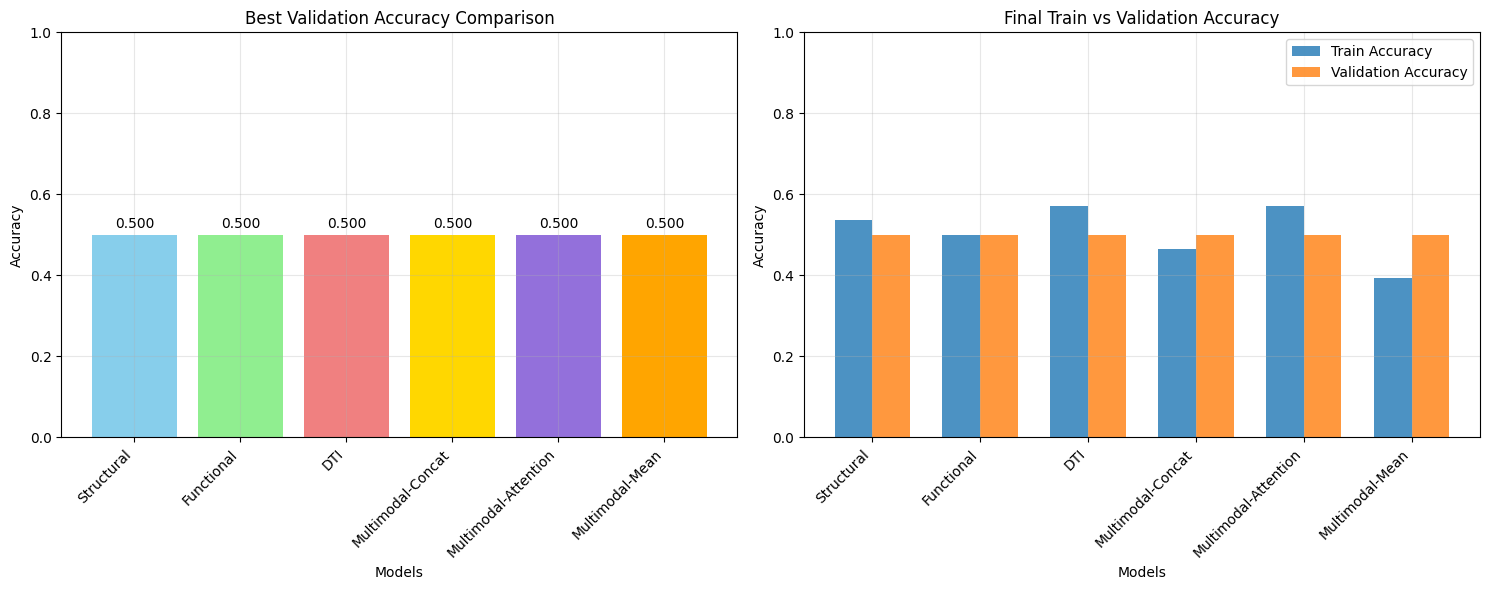


🏆 BEST PERFORMING MODEL: Structural
   Best Validation Accuracy: 0.5000

📋 DETAILED PERFORMANCE REPORT
Rank  Model                     Best Val Acc Final Val Acc  Epochs  
--------------------------------------------------------------------------------
1     Structural                0.5000       0.5000         21      
2     Functional                0.5000       0.5000         21      
3     DTI                       0.5000       0.5000         21      
4     Multimodal-Concat         0.5000       0.5000         21      
5     Multimodal-Attention      0.5000       0.5000         21      
6     Multimodal-Mean           0.5000       0.5000         21      

🔍 ANALYSIS:
   Best Individual Model: 0.5000
   Best Multimodal Model: 0.5000
   Multimodal Improvement: 0.0000

   Fusion Method Comparison:
     Concat: 0.5000
     Attention: 0.5000
     Mean: 0.5000

🎉 EVALUATION COMPLETE!
All models have been trained and evaluated on 229 subjects (134 Autism, 95 Control)


In [303]:
def evaluate_all_models(
    structural_trainer=None, 
    functional_trainer=None, 
    dti_trainer=None, 
    multimodal_trainers=None
):
    """Comprehensive evaluation of all trained models"""
    
    print("🎯 COMPREHENSIVE MODEL EVALUATION")
    print("=" * 60)
    
    results_summary = {}
    models_to_evaluate = {}
    
    if structural_trainer is not None:
        models_to_evaluate['Structural'] = structural_trainer
    if functional_trainer is not None:
        models_to_evaluate['Functional'] = functional_trainer
    if dti_trainer is not None:
        models_to_evaluate['DTI'] = dti_trainer
    if multimodal_trainers is not None:
        for fusion_method, trainer in multimodal_trainers.items():
            models_to_evaluate[f'Multimodal-{fusion_method.capitalize()}'] = trainer
    
    if not models_to_evaluate:
        print("❌ No trained models found. Please run the training sections first.")
        return {}
    
    # Evaluate each model
    for model_name, trainer in models_to_evaluate.items():
        print(f"\n📊 Evaluating {model_name}...")
        
        # Get the best validation accuracy from training
        best_acc = max(trainer.val_accs) if trainer.val_accs else 0
        
        # Get final epoch metrics
        if trainer.val_accs:
            final_train_acc = trainer.train_accs[-1]
            final_val_acc = trainer.val_accs[-1]
            final_train_loss = trainer.train_losses[-1]
            final_val_loss = trainer.val_losses[-1]
        else:
            final_train_acc = final_val_acc = final_train_loss = final_val_loss = 0
        
        results_summary[model_name] = {
            'best_val_accuracy': best_acc,
            'final_train_accuracy': final_train_acc,
            'final_val_accuracy': final_val_acc,
            'final_train_loss': final_train_loss,
            'final_val_loss': final_val_loss,
            'num_epochs': len(trainer.train_accs)
        }
        
        print(f"   Best Validation Accuracy: {best_acc:.4f}")
        print(f"   Final Train Accuracy: {final_train_acc:.4f}")
        print(f"   Final Validation Accuracy: {final_val_acc:.4f}")
    
    return results_summary

def plot_model_comparison(results_summary):
    """Plot comparison of all model results"""
    
    if not results_summary:
        print("❌ No results to plot")
        return
    
    # Extract data for plotting
    model_names = list(results_summary.keys())
    best_val_accs = [results_summary[name]['best_val_accuracy'] for name in model_names]
    final_val_accs = [results_summary[name]['final_val_accuracy'] for name in model_names]
    
    # Create comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Best validation accuracy comparison
    bars1 = ax1.bar(range(len(model_names)), best_val_accs, 
                    color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'mediumpurple', 'orange'][:len(model_names)])
    ax1.set_title('Best Validation Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Models')
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, best_val_accs):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Training vs Validation accuracy
    x = np.arange(len(model_names))
    width = 0.35
    
    train_accs = [results_summary[name]['final_train_accuracy'] for name in model_names]
    val_accs = [results_summary[name]['final_val_accuracy'] for name in model_names]
    
    bars2 = ax2.bar(x - width/2, train_accs, width, label='Train Accuracy', alpha=0.8)
    bars3 = ax2.bar(x + width/2, val_accs, width, label='Validation Accuracy', alpha=0.8)
    
    ax2.set_title('Final Train vs Validation Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Models')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.legend()
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find best model
    best_model_name = max(results_summary.keys(), key=lambda x: results_summary[x]['best_val_accuracy'])
    best_accuracy = results_summary[best_model_name]['best_val_accuracy']
    
    print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
    print(f"   Best Validation Accuracy: {best_accuracy:.4f}")
    
    return best_model_name

def generate_detailed_report(results_summary):
    """Generate a detailed performance report"""
    
    print(f"\n📋 DETAILED PERFORMANCE REPORT")
    print("=" * 80)
    
    # Sort models by best validation accuracy
    sorted_models = sorted(results_summary.items(), 
                          key=lambda x: x[1]['best_val_accuracy'], 
                          reverse=True)
    
    print(f"{'Rank':<5} {'Model':<25} {'Best Val Acc':<12} {'Final Val Acc':<14} {'Epochs':<8}")
    print("-" * 80)
    
    for rank, (model_name, metrics) in enumerate(sorted_models, 1):
        print(f"{rank:<5} {model_name:<25} {metrics['best_val_accuracy']:<12.4f} "
              f"{metrics['final_val_accuracy']:<14.4f} {metrics['num_epochs']:<8}")
    
    # Analysis
    print(f"\n🔍 ANALYSIS:")
    
    # Individual vs Multimodal comparison
    individual_models = ['Structural', 'Functional', 'DTI']
    multimodal_models = [name for name in results_summary.keys() if 'Multimodal' in name]
    
    if individual_models and multimodal_models:
        best_individual = max([results_summary[name]['best_val_accuracy'] 
                              for name in individual_models if name in results_summary])
        best_multimodal = max([results_summary[name]['best_val_accuracy'] 
                              for name in multimodal_models])
        
        print(f"   Best Individual Model: {best_individual:.4f}")
        print(f"   Best Multimodal Model: {best_multimodal:.4f}")
        print(f"   Multimodal Improvement: {best_multimodal - best_individual:.4f}")
    
    # Fusion method comparison
    fusion_results = {name.split('-')[1]: results_summary[name]['best_val_accuracy'] 
                     for name in multimodal_models}
    if fusion_results:
        print(f"\n   Fusion Method Comparison:")
        for fusion_method, accuracy in sorted(fusion_results.items(), key=lambda x: x[1], reverse=True):
            print(f"     {fusion_method}: {accuracy:.4f}")

# Check if trainers exist in the current scope and call the evaluation function with them
if any(name in globals() for name in ['structural_trainer', 'functional_trainer', 'dti_trainer']) or 'multimodal_trainers' in globals():
    
    results_summary = evaluate_all_models(
        structural_trainer=globals().get('structural_trainer', None),
        functional_trainer=globals().get('functional_trainer', None),
        dti_trainer=globals().get('dti_trainer', None),
        multimodal_trainers=globals().get('multimodal_trainers', None),
    )
    
    if results_summary:
        # Plot comparisons
        best_model = plot_model_comparison(results_summary)
        
        # Generate detailed report
        generate_detailed_report(results_summary)
        
        print(f"\n🎉 EVALUATION COMPLETE!")
        print(f"All models have been trained and evaluated on 229 subjects (134 Autism, 95 Control)")
else:
    print("⚠️ No trained models found. Please run the training sections first.")
